In [0]:
# Generate NFTs using Deep Convolutional Generative Adversarial Networks
# Taken from the following medium blog by Bao Tram Duong: 
# https://medium.com/mlearning-ai/generate-nft-cryptopunks-with-deep-convolutional-generative-adversarial-network-dcgan-db35f0a1adb4

Out[1]: 1

In [0]:
!pip install opencv-python

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import random
from tqdm import tqdm
import cv2 as cv
import PIL
from PIL import Image
!pip install plotly
import plotly.express as px
from IPython import display

import tensorflow as tf
from tensorflow import keras

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Requirement already satisfied: plotly in /databricks/python3/lib/python3.8/site-packages (5.5.0)
Requirement already satisfied: six in /databricks/python3/lib/python3.8/site-packages (from plotly) (1.15.0)
Requirement already satisfied: tenacity>=6.2.0 in /databricks/python3/lib/python3.8/site-packages (from plotly) (6.2.0)
 WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

In [0]:
# Set the directories for the training images (NFTs)
image_dir = "/dbfs/FileStore/nft-hackathon/training_imgs/imgs"
image_root = "/dbfs/FileStore/nft-hackathon/training_imgs/"
data_dir = "/dbfs/FileStore/nft-hackathon/training_imgs/"

Sample 100 CryptoPunks

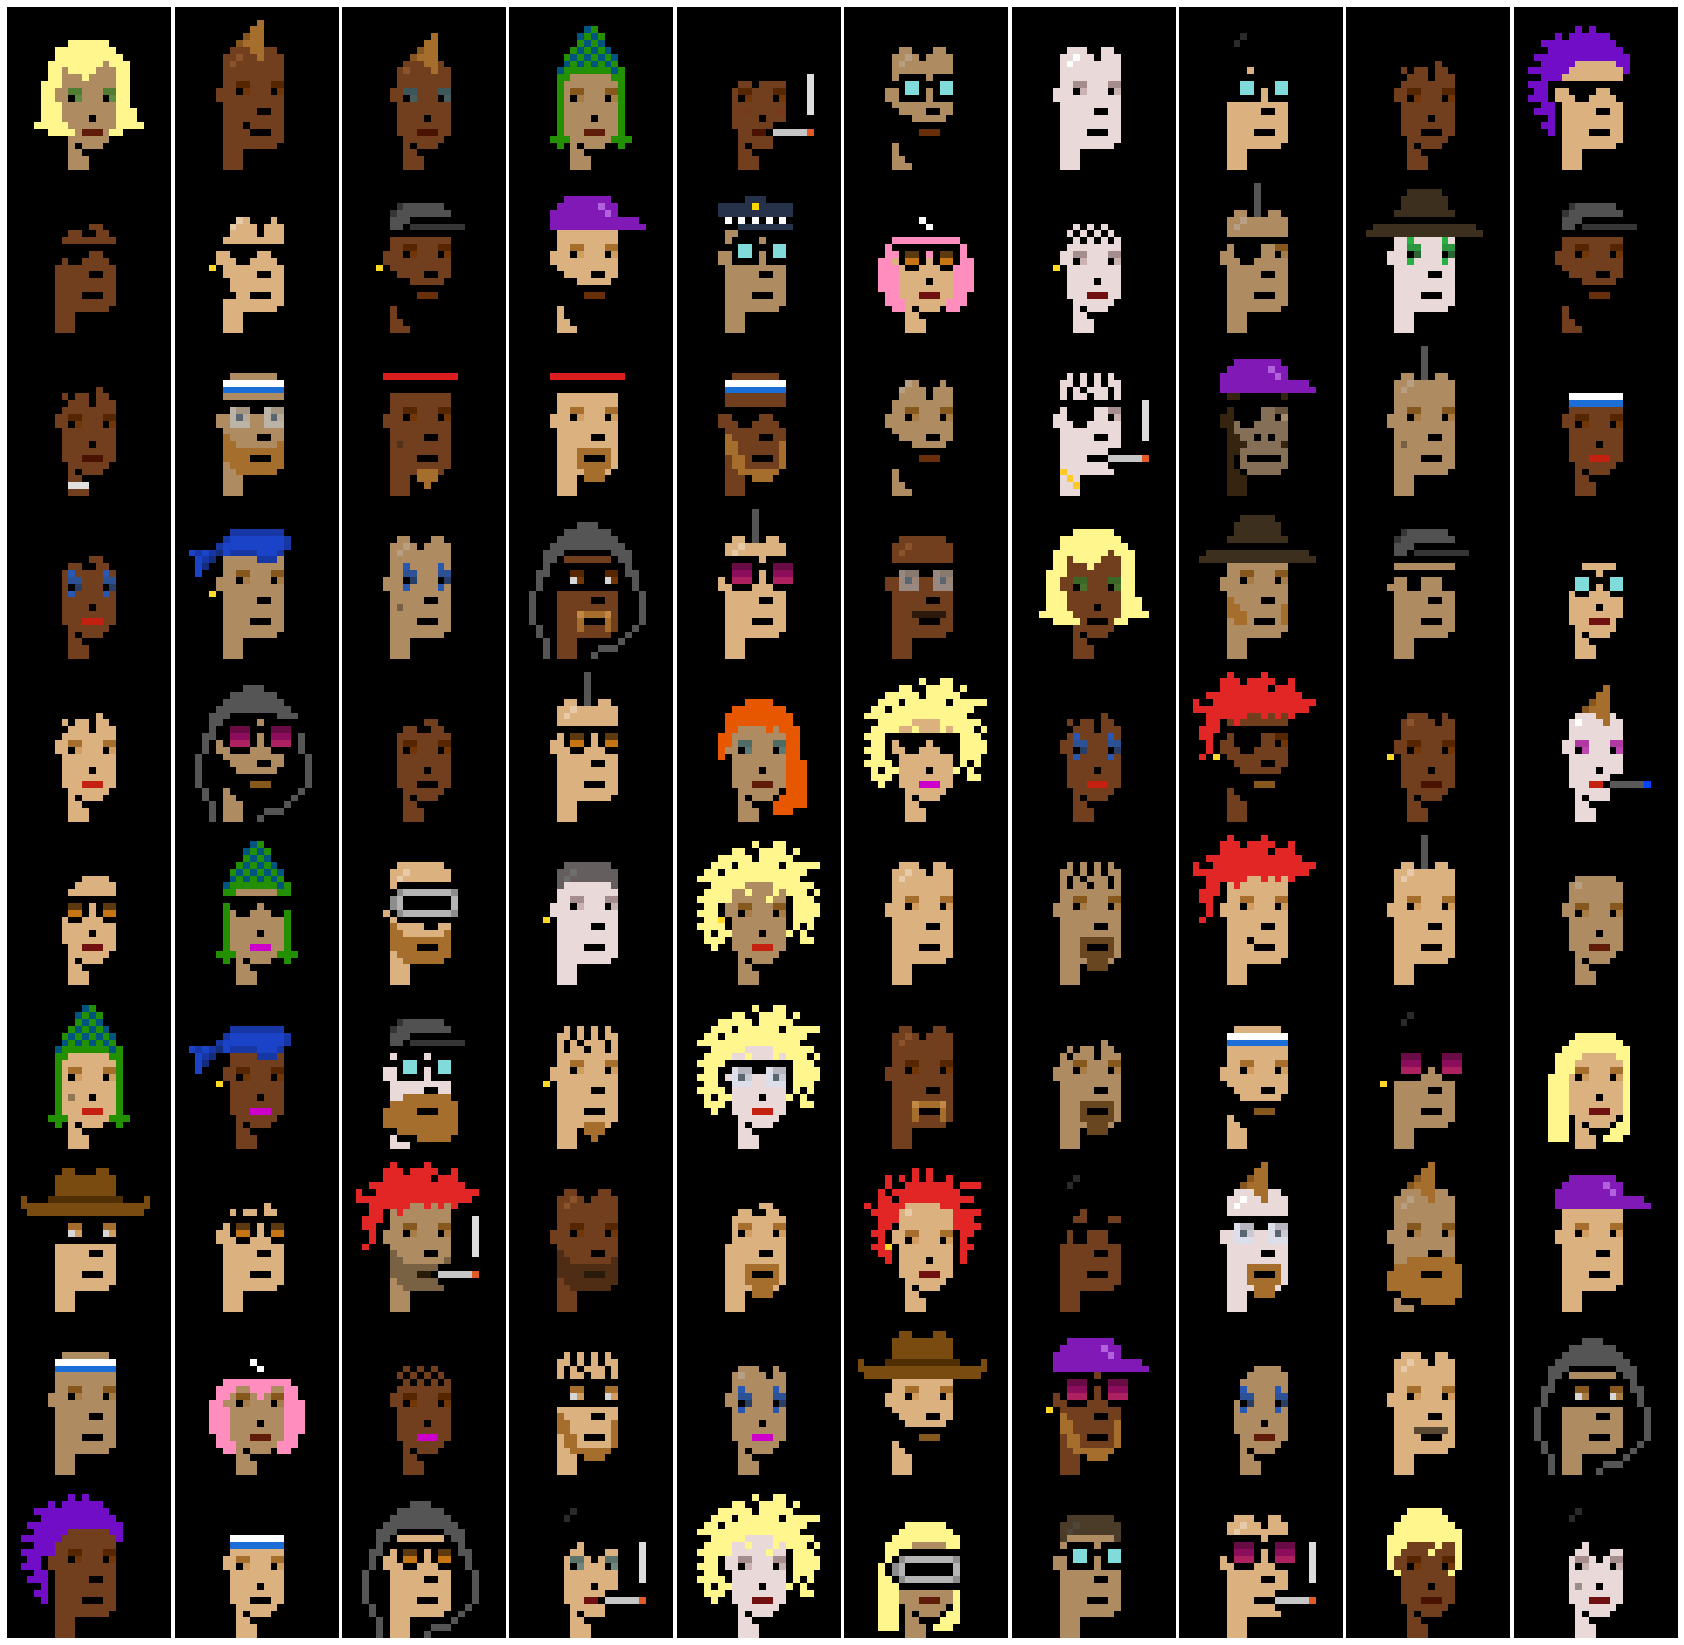

In [0]:
#look at 100 samples
#define number of rows and cols
no_plots = 10*10

#define path
images = glob.glob("/dbfs/FileStore/nft-hackathon/training_imgs/imgs/*.png")

plt.rcParams['figure.figsize'] = (30, 30)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample 100 CryptoPunks")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    plt.subplot(10, 10, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB)) #covert color space
plt.show()

In [0]:
def print_tensor_images(images_tensor):
    
    '''
    Function for visualizing images: Given a tensor of images, prints the images.
    '''
        
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
        
    plt.show()

In [0]:
#helper display function
def tensor_imshow(img,dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [0]:
def get_dataloader(batch_size,           #batch size during training
                   image_size,           #spatial size of training images
                   data_dir=image_dir,   #root directory for dataset
                   num_workers=3):       #number of sub-processes
    
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
    
    #create transformer to transform images
    transform = transforms.Compose([transforms.Resize((image_size, image_size)),  #resize
                                    transforms.ToTensor(),                        #convert to tensor
                                    transforms.Normalize(*stats)])                #normalize to be between -1 and 1
    
    #create the dataset
    dataset = datasets.ImageFolder(root=data_dir,
                                   transform=transform)
    
    #create the dataloader
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=num_workers,
                                              pin_memory=True)
    
    return data_loader

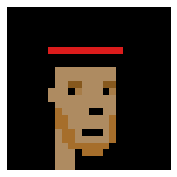

In [0]:
#test dataloader
batch_size, image_size = 5, 24

train_loader = get_dataloader(batch_size,
                              image_size,
                              image_root)

dataiter = iter(train_loader) #dataloader is an iterator

img,_ = next(dataiter)
sample_img = img[-1]

#display tensor image
tensor_imshow(sample_img)

In [0]:
class Generator(nn.Module):       #signals neural network
    def __init__(self, 
                 z_dim=100,      #noise vector
                 im_chan=3,      #color chanel, 3 for red green blue
                 hidden_dim=64): #spatial size of feature map (conv)
        
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.im_chan = im_chan
        self.hidden_dim = hidden_dim
        
        self.generator_cnn = nn.Sequential(self.make_gen_block(z_dim, hidden_dim*8, stride=1, padding=0),   
                                           #(64*8) x 4 x 4
                                           self.make_gen_block(hidden_dim*8, hidden_dim*4),                           
                                           #(64*4) x 8 x 8
                                           self.make_gen_block(hidden_dim*4, hidden_dim*2),                           
                                           #(64*2) x 16 x 16
                                           self.make_gen_block(hidden_dim*2, hidden_dim),                             
                                           #(64) x 32 x 32
                                           self.make_gen_block(hidden_dim, im_chan, final_layer=True))
    
    def make_gen_block(self, 
                       im_chan,     #image dimension
                       op_chan,     #output dimension
                       kernel_size=4, 
                       stride=2, 
                       padding=1, 
                       final_layer=False): 
        
        layers = []
        #de-convolutional layer
        layers.append(nn.ConvTranspose2d(im_chan,     
                                         op_chan, 
                                         kernel_size, 
                                         stride, 
                                         padding, 
                                         bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator_cnn(x)

    def get_noise(n_samples, 
                  z_dim, 
                  device='cpu'):
        return torch.randn(n_samples, 
                           z_dim, 
                           device=device)

In [0]:
#test Generator
noise = Generator.get_noise(n_samples=5,
                            z_dim=100)

g = Generator(z_dim=100,
              im_chan=3,
              hidden_dim=64)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, 
                 im_chan=3,       #image channels, 3 for red green blue
                 conv_dim=64,     #spatial dimension of feature map
                 image_size=64):  #spatial size of training images
        
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(self.make_disc_block(im_chan, conv_dim),
                                      self.make_disc_block(conv_dim, conv_dim*2),
                                      self.make_disc_block(conv_dim*2, conv_dim*4),
                                      self.make_disc_block(conv_dim*4, conv_dim*8),
                                      #no need a sigmoid here since it is included in the loss function
                                      self.make_disc_block(conv_dim*8, 1, padding=0, final_layer=True)) 
        
        
    def make_disc_block(self,
                        im_chan,
                        op_chan,
                        kernel_size=4,
                        stride=2,
                        padding=1,
                        final_layer=False):
        layers = []
        layers.append(nn.Conv2d(im_chan,
                                op_chan,
                                kernel_size,
                                stride,
                                padding,
                                bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    #given an image tensor, returns a 1-dimension tensor representing fake/real
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [0]:
#test Discriminator
d = Discriminator(im_chan=3,
                  conv_dim=64,
                  image_size=64)

In [0]:
#custom weights initialization to randomly initialize all weights
#mean=0, stdev=0.2
def weights_init_normal(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02) 
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [0]:
def real_loss(D_out,device='cuda'):
    
    #initialize BCELoss function
    criterion = nn.BCEWithLogitsLoss()
    
    #batch size
    #batch_size = D_out.size(0)
    batch_size = D_out.shape
    
    #labels will be used when calculating the losses
    #real labels = 1 and lable smoothing => 0.9
    labels = torch.ones(batch_size, device=device)*0.9 
    
    #loss = criterion(D_out.squeeze(), labels)
    loss = criterion(D_out, labels)
    return loss

In [0]:
def fake_loss(D_out, device='cuda'):
    
    #initialize BCELoss function
    criterion = nn.BCEWithLogitsLoss()
    
    #batch size
    #batch_size = D_out.size(0)
    batch_size = D_out.shape
    
    #labels will be used when calculating the losses
    #fake labels = 0
    labels = torch.zeros(batch_size,
                         device=device) 
    
    #loss = criterion(D_out.squeeze(), labels)
    loss = criterion(D_out, labels)
    return loss

In [0]:
def train(D, G, 
          n_epochs,
          dataloader,
          d_optimizer,
          g_optimizer,
          z_dim,
          print_every=50,
          device='cuda'):
    
    #to keep track of the generator’s learning progression, 
    #we will generate a fixed batch of latent vectors that are drawn from a Gaussian distribution   
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,
                                  z_dim=z_dim,
                                  device=device)
    
    for epoch in range(1,n_epochs+1):
        #use dataloader to fetch batches
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            #Part 1: Train the Discriminator ========================================================
            #goal: to maximize the probability of correctly classifying a given input as real or fake
            
            #zero out the gradients before backpropagation
            d_optimizer.zero_grad()
            
            ##classify all-real batch
            d_real_op = D(real_images) #average output (across the batch) of the discriminator
            d_real_loss = real_loss(d_real_op,
                                    device=device)
            
            #train with all-fake batch
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            fake_images = G(noise)
            
            #classify all-fake batch
            d_fake_op = D(fake_images) #average output (across the batch) of the generator
            d_fake_loss = fake_loss(d_fake_op,
                                    device=device)
            
            #total loss
            d_loss = d_real_loss + d_fake_loss
            
            #update gradients
            d_loss.backward()
            #update optimizer
            d_optimizer.step()
            
            #Part 2: Train the Generator ==============================================================
            #zero out the gradients before backpropagation
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,
                                        z_dim=z_dim,
                                        device=device)
            
            #use discriminator to classify generator's output
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out, 
                               device=device) 
            #update gradients
            g_loss.backward()
            #update optimizer
            g_optimizer.step()
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(epoch, 
                                                                               n_epochs, 
                                                                               d_loss.item(),  #keep track of loss
                                                                               g_loss.item())) #keep track of loss
        """
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()
        """

In [0]:
#hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ", device)

#incorrect hyperparameter settings lead to mode collapse
#we will follow Goodfellow’s paper
z_dim = 100       #noise
beta_1 = 0.5      #as specified in the original DCGAN paper
beta_2 = 0.999 
lr = 0.0002       #as specified in the original DCGAN paper
n_epochs = 100
batch_size = 128
image_size = 64

Device is cuda

In [0]:
#initialize generator
generator = Generator(z_dim, 
                      im_chan=3, 
                      hidden_dim=64).to(device)


#initialize discriminator
discriminator = Discriminator(im_chan=3, 
                              conv_dim=64, 
                              image_size=image_size).to(device)

#setup Adam optimizers for generator
g_optimizer = optim.Adam(generator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

#setup Adam optimizers for discriminator
d_optimizer = optim.Adam(discriminator.parameters(), 
                         lr=lr, 
                         betas=(beta_1, beta_2))

#setup dataloader
dataloader = get_dataloader(batch_size, 
                            image_size, 
                            image_root)

In [0]:
#start training
%time
n_epochs = 100
train(discriminator,
      generator,
      n_epochs,
      dataloader,
      d_optimizer,
      g_optimizer,
      z_dim,
      print_every=1,
      device=device)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs
Epoch [ 1/ 100] | d_loss: 0.3596 | g_loss: 5.4347
Epoch [ 2/ 100] | d_loss: 1.3856 | g_loss: 5.9266
Epoch [ 3/ 100] | d_loss: 0.7076 | g_loss: 1.9980
Epoch [ 4/ 100] | d_loss: 0.4969 | g_loss: 2.9241
Epoch [ 5/ 100] | d_loss: 0.5413 | g_loss: 3.7571
Epoch [ 6/ 100] | d_loss: 0.3989 | g_loss: 2.7720
Epoch [ 7/ 100] | d_loss: 0.7019 | g_loss: 2.5836
Epoch [ 8/ 100] | d_loss: 0.3765 | g_loss: 2.9196
Epoch [ 9/ 100] | d_loss: 0.6570 | g_loss: 3.0733
Epoch [ 10/ 100] | d_loss: 1.7446 | g_loss: 6.4490

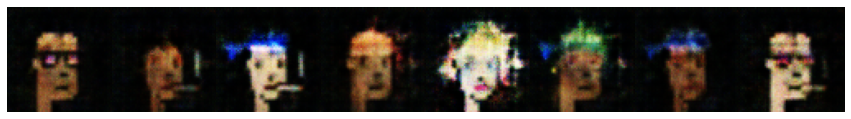

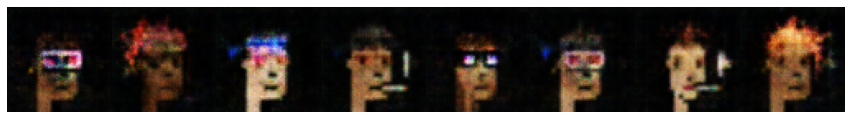

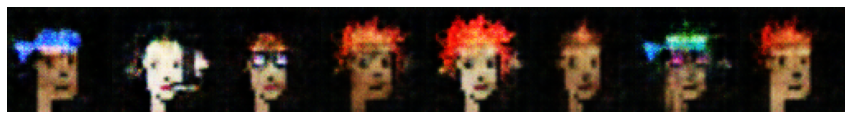

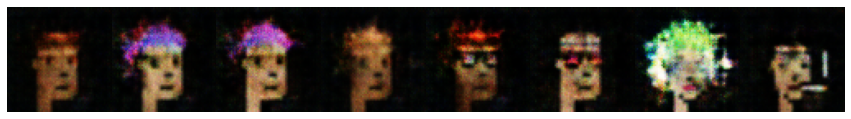

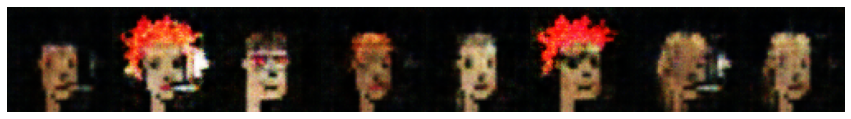

In [0]:
#sample generation
generator.to(device)
generator.eval()
sample_size=8
for i in range(5):
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)    
    sample_image = generator(fixed_z)
    print_tensor_images(sample_image)